<a href="https://colab.research.google.com/github/tomonoshin-lab/fl-consortium-incentive-study/blob/main/Copy_of_20251123_ipsj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. ディレクトリと__init__.py作成

In [ ]:
%%bash
mkdir -p model analysis
touch model/__init__.py analysis/__init__.py


2. config.py

In [ ]:
%%writefile config.py
import numpy as np

# =========================
# Reproducibility
# =========================
BASE_SEED = 42  # ここを変えれば全実験が一括で変わります

PARAMS = {
    'NUM_COMPANIES'    : 100,
    'TURNS'            : 100,
    'INVITE_NUM'       : 25,
    'COLLISIONS'       : 0,
    'NEW_ENTRIES'      : 25,
    'MAX_AGE'          : 40,
    'CONSORTIUM_COEF'  : 0.30,
    'NON_CONS_r'       : 0.15,
    'alpha_con'        : 500,
    'alpha_non'        : 500,
    'DISTRIBUTION_MODE': 0.0,
    'INERTIA_STATIC'   : 1.0,   # 静的要因 σ₀
    'INERTIA_DYNAMIC'  : 0.1,   # 動的要因 σ₁（在籍年数係数）
}
SNAPSHOT_TURN = PARAMS['TURNS']
RUNS = 100
MODES = np.arange(0, 1.01, 0.2)


Writing config.py


3. model/helpers.py

In [ ]:
%%writefile model/helpers.py
import numpy as np
from config import PARAMS

def consortium_return_avg(avg_size, params=PARAMS):
    c, a = params['CONSORTIUM_COEF'], params['alpha_con']
    return avg_size*c/(1+(avg_size/a)**2)

def consortium_total_profit(sizes_in, params=PARAMS):
    if sizes_in.size==0: return 0.0
    return consortium_return_avg(sizes_in.mean(),params)*sizes_in.size

def non_cons_growth(sizes_out, params=PARAMS):
    r,a = params['NON_CONS_r'], params['alpha_non']
    return sizes_out * r/(1+(sizes_out/a)**2)

def p_join_equal(sizes_in, size, params=PARAMS):
    avg = sizes_in.mean() if sizes_in.size>0 else 0.0
    cb = consortium_return_avg(avg,params)
    nb = non_cons_growth(size,params)
    return cb/(cb+nb) if (cb+nb)>0 else 0.0

def p_join_profit(sizes_in, size, params=PARAMS):
    tot = consortium_total_profit(sizes_in,params)
    ssum= sizes_in.sum()
    share = tot*size/ssum if ssum>0 else 0.0
    nb = non_cons_growth(size,params)
    return share/(share+nb) if (share+nb)>0 else 0.0

def death_probs(ages):
    probs = np.empty_like(ages, dtype=float)
    probs[ages<=10] = 1/15
    probs[(ages>10)&(ages<=20)] = 1/20
    probs[(ages>20)&(ages<=30)] = 1/15
    probs[(ages>30)&(ages<=40)] = 1/10
    probs[ages>40] = 1/5
    return probs


Writing model/helpers.py


4. model/simulator.py

In [ ]:
%%writefile model/simulator.py
import numpy as np
from config import PARAMS, SNAPSHOT_TURN
from model.helpers import (
    consortium_return_avg,
    consortium_total_profit,
    non_cons_growth,
    p_join_equal,
    p_join_profit,
    death_probs
)

def p_profit_based(sizes_in, size, mode, params=PARAMS):
    """加入/脱退の利益比較（mode=0:平均分配, mode=1:利益シェア, 混合も可）"""
    p_eq = p_join_equal(sizes_in, size, params)
    p_pf = p_join_profit(sizes_in, size, params)
    return (1 - mode) * p_eq + mode * p_pf

def run_simulation_np(record_snapshots=False, snapshot_turns=None, rng=None):
    """
    rng: numpy.random.Generator を外から渡せるようにし、
         外側でSeedSequence管理することで実行ごとの再現性を保証
    """
    if rng is None:
        rng = np.random.default_rng(0)

    N = PARAMS['NUM_COMPANIES']
    sizes = np.arange(1, N + 1, dtype=float)
    rng.shuffle(sizes)

    ages0 = np.clip(rng.normal(20, 5, N).astype(int), 0, PARAMS['MAX_AGE'])
    birth = -ages0.copy()

    in_cons = np.zeros(N, bool)
    in_cons[rng.choice(N, PARAMS['INVITE_NUM'], replace=False)] = True

    ts = np.zeros((PARAMS['TURNS'] + 1, 4))
    snapshots = {} if record_snapshots else None

    sigma0 = PARAMS.get('INERTIA_STATIC', 0.0)
    sigma1 = PARAMS.get('INERTIA_DYNAMIC', 0.0)

    for t in range(PARAMS['TURNS'] + 1):
        n_cons = in_cons.sum()
        s_cons = sizes[in_cons].sum()
        n_non = in_cons.size - n_cons
        s_non = sizes[~in_cons].sum()
        ts[t] = [n_cons, s_cons, n_non, s_non]

        if record_snapshots and snapshot_turns and t in snapshot_turns:
            snapshots[t] = {'sizes': sizes.copy(), 'in_cons': in_cons.copy()}

        if t == PARAMS['TURNS']:
            break

        x = PARAMS['DISTRIBUTION_MODE']

        outsiders = np.where(~in_cons)[0]
        k = min(PARAMS['INVITE_NUM'], outsiders.size)
        pick = rng.choice(outsiders, k, replace=False)
        sin = sizes[in_cons]

        # --- 加入判定 ---
        for i in pick:
            p = p_profit_based(sin, sizes[i], x)
            if rng.random() < p:
                in_cons[i] = True

        sin = sizes[in_cons]
        idxs = np.where(in_cons)[0]
        tenures = (t - birth[idxs])

        # --- 脱退判定 ---
        for idx, i in enumerate(idxs):
            p = p_profit_based(sin, sizes[i], x)
            tenure = tenures[idx]
            p_leave = (1 - p) / (1 + sigma0 + sigma1 * tenure)
            if rng.random() < p_leave:
                in_cons[i] = False

        # --- 競合消滅（COLLISIONS） ---
        n = sizes.size
        m = min(PARAMS['COLLISIONS'], n // 2)
        a = rng.integers(0, n, m)
        b = rng.integers(0, n, m)
        sa, sb = sizes[a], sizes[b]
        rm = np.zeros(n, bool)
        mask_a = sa < sb
        mask_b = sb < sa
        rm[a[mask_a]] = True
        rm[b[mask_b]] = True
        eq = sa == sb
        rm[a[eq]] = True
        rm[b[eq]] = True
        keep = ~rm

        sizes = sizes[keep]
        in_cons = in_cons[keep]
        birth = birth[keep]

        # --- 新規参入 ---
        ne = PARAMS['NEW_ENTRIES']
        sizes = np.concatenate([sizes, rng.integers(1, 101, ne)])
        in_cons = np.concatenate([in_cons, np.zeros(ne, bool)])
        birth = np.concatenate([birth, np.full(ne, t)])

        # --- 成長 ---
        sin = sizes[in_cons]
        avg = sin.mean() if sin.size > 0 else 0.0
        totp = consortium_total_profit(sin)
        tot_s = sin.sum()

        growth_non = non_cons_growth(sizes[~in_cons])

        share = totp * sizes[in_cons] / tot_s if tot_s > 0 else 0.0
        growth_con = (1 - x) * consortium_return_avg(avg) + x * share

        sizes[~in_cons] += growth_non
        sizes[in_cons] += growth_con

        # --- death ---
        ages = t - birth
        probs = death_probs(ages)
        keep = rng.random(sizes.size) >= probs
        sizes = sizes[keep]
        in_cons = in_cons[keep]
        birth = birth[keep]

    return (ts, snapshots) if record_snapshots else ts

run_simulation = run_simulation_np


Writing model/simulator.py


5. analysis/gini.py

In [ ]:
%%writefile analysis/gini.py
import numpy as np

def gini_coefficient(x):
    x = np.asarray(x, float)
    if x.size==0: return np.nan
    sx = np.sort(x); n=sx.size; idx=np.arange(1,n+1)
    return 2*(idx*sx).sum()/(n*sx.sum()) - (n+1)/n


Writing analysis/gini.py


6. analysis/visualize.py

In [ ]:
%%writefile analysis/visualize.py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

from config import PARAMS, SNAPSHOT_TURN, RUNS, MODES, BASE_SEED
from model.simulator import run_simulation
from analysis.gini import gini_coefficient

def rngs_for_mode(mode, runs=RUNS, seed_base=BASE_SEED):
    """
    modeごとに SeedSequence を分けて子rngをruns個生成。
    これにより、実行順序に依存せず必ず同じ結果が出ます。
    """
    ss = np.random.SeedSequence(seed_base + int(round(mode * 1000)))
    children = ss.spawn(runs)
    for c in children:
        yield np.random.default_rng(c)

def compute_time_series(mode, return_size_sum=False):
    PARAMS['DISTRIBUTION_MODE'] = mode
    res = [run_simulation(rng=rng) for rng in rngs_for_mode(mode)]
    agg = np.sum(res, axis=0) / RUNS
    if return_size_sum:
        return agg[:,1], agg[:,3]
    else:
        return agg[:,0], agg[:,2]

def plot_time_series(turns, mode_data_cons, mode_data_non, title, ylabel):
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(MODES)))
    marker_cycle = ['o', 's', '^', 'D', 'v', 'P']

    for i, mode in enumerate(MODES):
        color = colors[i]
        marker = marker_cycle[i % len(marker_cycle)]
        ax.plot(turns, mode_data_cons[i], '-', lw=2.5, marker=marker, ms=6, color=color,
                label=f"mode={mode:.1f} Con")
        ax.plot(turns, mode_data_non[i], '--', lw=2.5, marker=marker, ms=6, color=color,
                label=f"mode={mode:.1f} Non")

    ax.set_xlabel('Turn')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    fig.tight_layout()
    plt.show()

def plot_gini_coefficients(runs: int = RUNS, modes: np.ndarray = MODES):
    results = {'mode': [], 'all': [], 'cons': [], 'non': []}

    for mode in modes:
        PARAMS['DISTRIBUTION_MODE'] = mode

        gini_all_list, gini_cons_list, gini_non_list = [], [], []
        for rng in rngs_for_mode(mode, runs):
            _, snaps = run_simulation(record_snapshots=True,
                                      snapshot_turns=[SNAPSHOT_TURN],
                                      rng=rng)
            data = snaps[SNAPSHOT_TURN]
            sizes, in_cons = data['sizes'], data['in_cons']
            if len(sizes) == 0:
                continue

            gini_all_list.append(gini_coefficient(sizes))
            gini_cons_list.append(gini_coefficient(sizes[in_cons]) if np.any(in_cons) else np.nan)
            gini_non_list.append(gini_coefficient(sizes[~in_cons]) if np.any(~in_cons) else np.nan)

        results['mode'].append(mode)
        results['all'].append(np.nanmean(gini_all_list))
        results['cons'].append(np.nanmean(gini_cons_list))
        results['non'].append(np.nanmean(gini_non_list))

    plt.figure(figsize=(8, 6))
    plt.plot(results['mode'], results['all'], '-o', lw=2.5, ms=6, label="All Firms")
    plt.plot(results['mode'], results['cons'], '-s', lw=2.5, ms=6, label="Consortium Firms")
    plt.plot(results['mode'], results['non'], '-^', lw=2.5, ms=6, label="Non-Consortium Firms")
    plt.xlabel('Mode')
    plt.ylabel('Gini Coefficient')
    plt.title('Gini Coefficient of Firm Sizes by Mode')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    df = pd.DataFrame(results)
    display(df)

def plot_avg_size_histograms(runs: int = RUNS, modes: np.ndarray = MODES):
    """
    各modeごとに全企業/所属/非所属の平均ヒストグラムを描き、
    さらに mean / mode / std を mode×グループで表としてまとめて出力。
    """
    bin_edges = np.arange(0, 1001, 50)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    summary_rows = []

    for mode in modes:
        PARAMS['DISTRIBUTION_MODE'] = mode

        all_sizes_runs, cons_sizes_runs, non_sizes_runs = [], [], []
        for rng in rngs_for_mode(mode, runs):
            _, snaps = run_simulation(record_snapshots=True,
                                      snapshot_turns=[SNAPSHOT_TURN],
                                      rng=rng)
            data = snaps[SNAPSHOT_TURN]
            sizes, in_cons = data['sizes'], data['in_cons']

            all_sizes_runs.append(sizes)
            cons_sizes_runs.append(sizes[in_cons])
            non_sizes_runs.append(sizes[~in_cons])

        all_sizes_concat  = np.concatenate(all_sizes_runs)  if len(all_sizes_runs)  else np.array([])
        cons_sizes_concat = np.concatenate(cons_sizes_runs) if len(cons_sizes_runs) else np.array([])
        non_sizes_concat  = np.concatenate(non_sizes_runs)  if len(non_sizes_runs)  else np.array([])

        hist_all, _  = np.histogram(all_sizes_concat, bins=bin_edges)
        hist_cons, _ = np.histogram(cons_sizes_concat, bins=bin_edges)
        hist_non, _  = np.histogram(non_sizes_concat, bins=bin_edges)

        avg_hist_all  = hist_all  / runs
        avg_hist_cons = hist_cons / runs
        avg_hist_non  = hist_non  / runs

        fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

        stats = [
            ("All Firms", all_sizes_concat,  avg_hist_all,  axes[0], 'tab:blue'),
            ("Consortium Firms", cons_sizes_concat, avg_hist_cons, axes[1], 'tab:green'),
            ("Non-Consortium Firms", non_sizes_concat, avg_hist_non, axes[2], 'tab:orange')
        ]

        for label, values, avg_hist, ax, color in stats:
            ax.bar(bin_centers, avg_hist, width=50, align='center', color=color, alpha=0.8)
            ax.set(title=f"Mode={mode:.1f} {label}", xlabel="Size")
            ax.set_xlim(0, 1000)
            ax.set_xticks(np.arange(0, 1001, 100))
            ax.set_ylim(0, 150)
            ax.set_yticks(np.arange(0, 151, 10))

            mean_val = np.mean(values) if len(values) > 0 else np.nan
            std_val  = np.std(values)  if len(values) > 0 else np.nan
            mode_val = bin_centers[np.argmax(avg_hist)] if avg_hist.sum() > 0 else np.nan

            ax.text(
                0.98, 0.95,
                f"Mean: {mean_val:.1f}\nMode: {mode_val:.1f}\nStd: {std_val:.1f}",
                ha='right', va='top', transform=ax.transAxes, fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
            )

            summary_rows.append({
                "mode": mode,
                "group": label,
                "mean": mean_val,
                "mode(bin_center)": mode_val,
                "std": std_val
            })

        axes[0].set_ylabel("Average Number of Firms")
        plt.tight_layout()
        plt.show()

    # === 要求②: mode×グループの記述統計表をまとめて表示 ===
    summary_df = pd.DataFrame(summary_rows)
    display(summary_df)
    return summary_df


Writing analysis/visualize.py


8. 動作確認

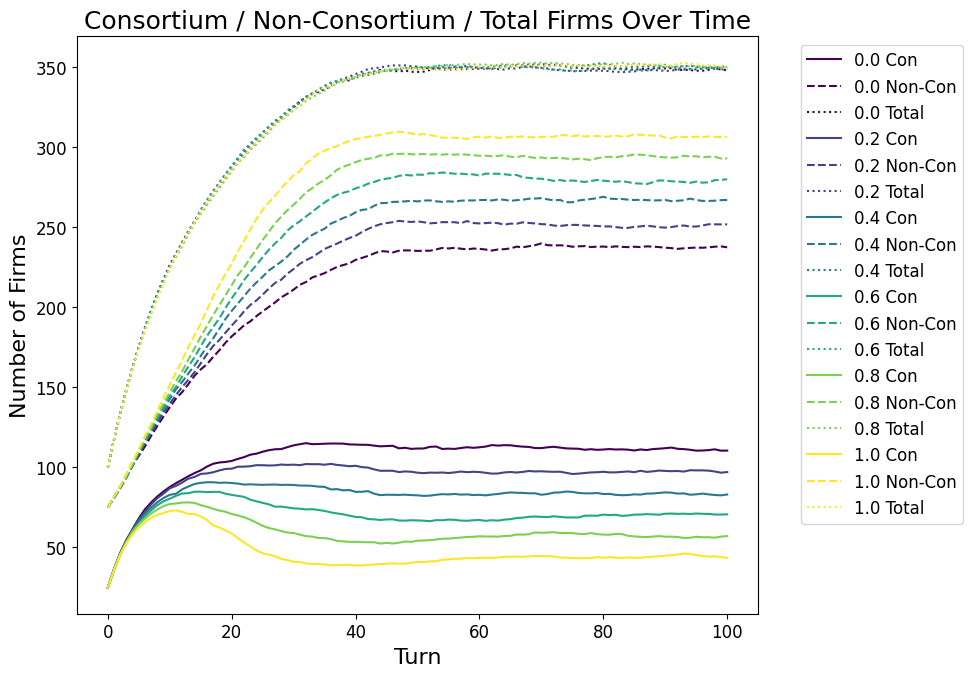

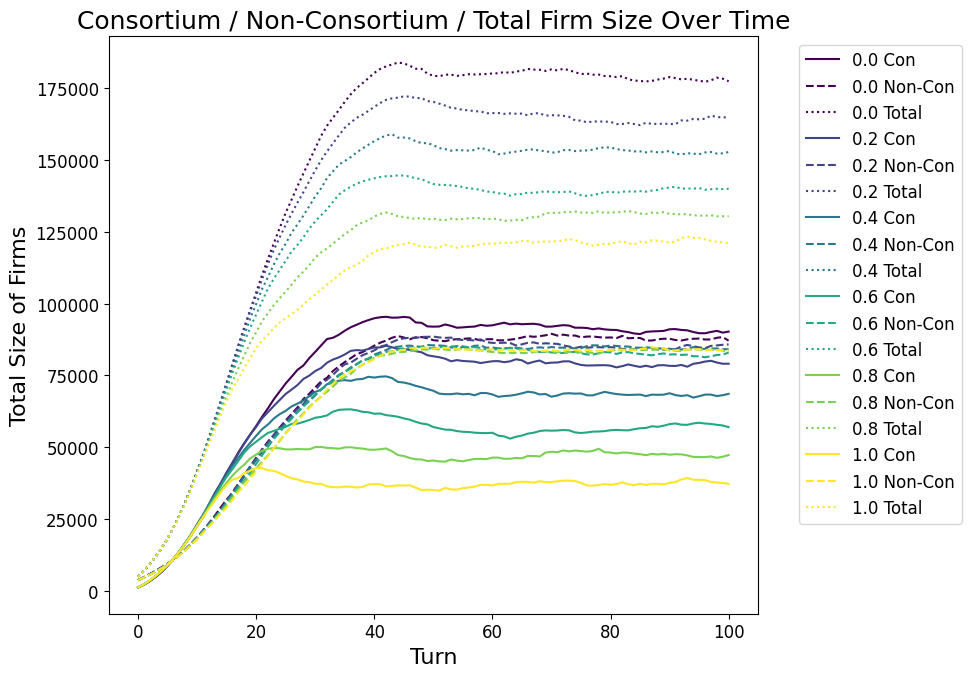

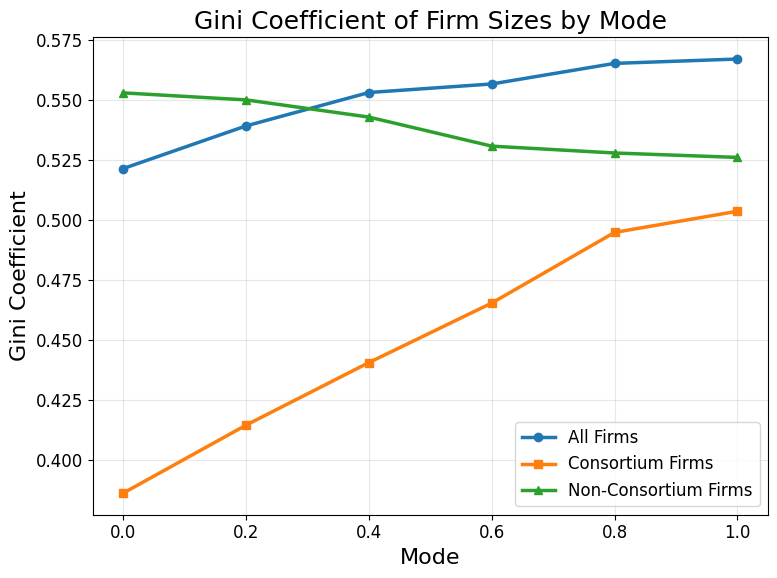

,mode,all,cons,non
0,0.0,0.521496,0.386142,0.553043
1,0.2,0.539280,0.414482,0.550114
2,0.4,0.553199,0.440563,0.542943
3,0.6,0.556759,0.465378,0.530831
4,0.8,0.565340,0.494833,0.527969
5,1.0,0.567160,0.503665,0.526129


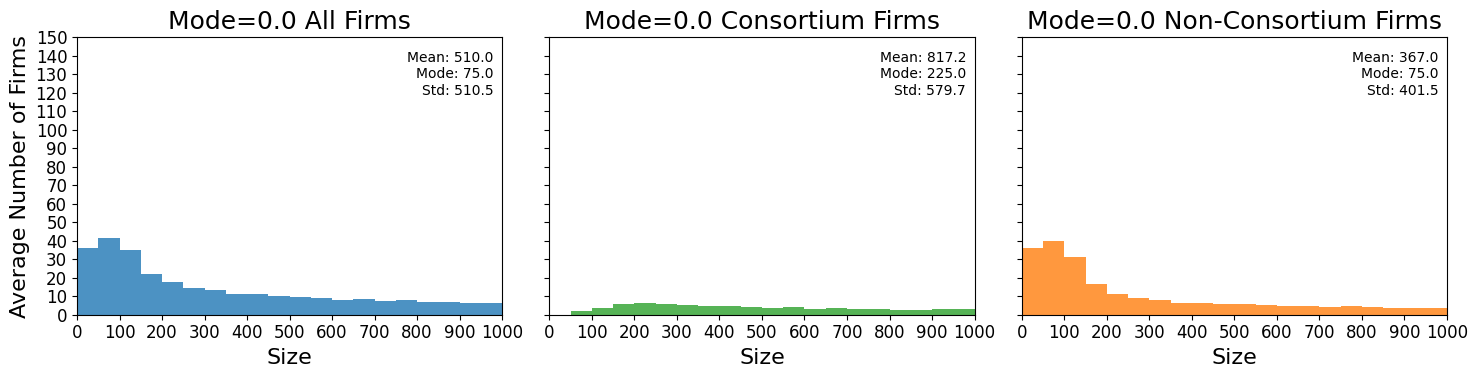

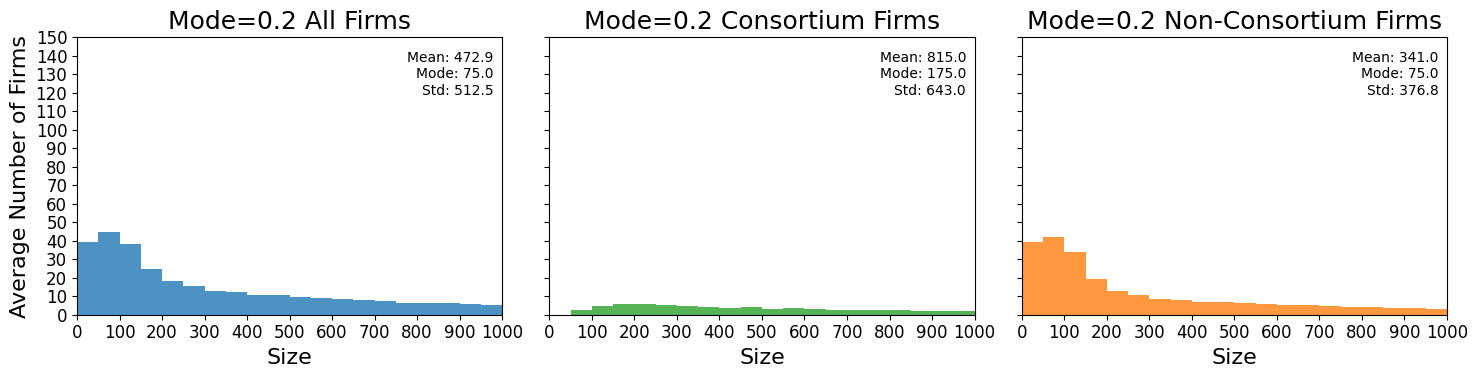

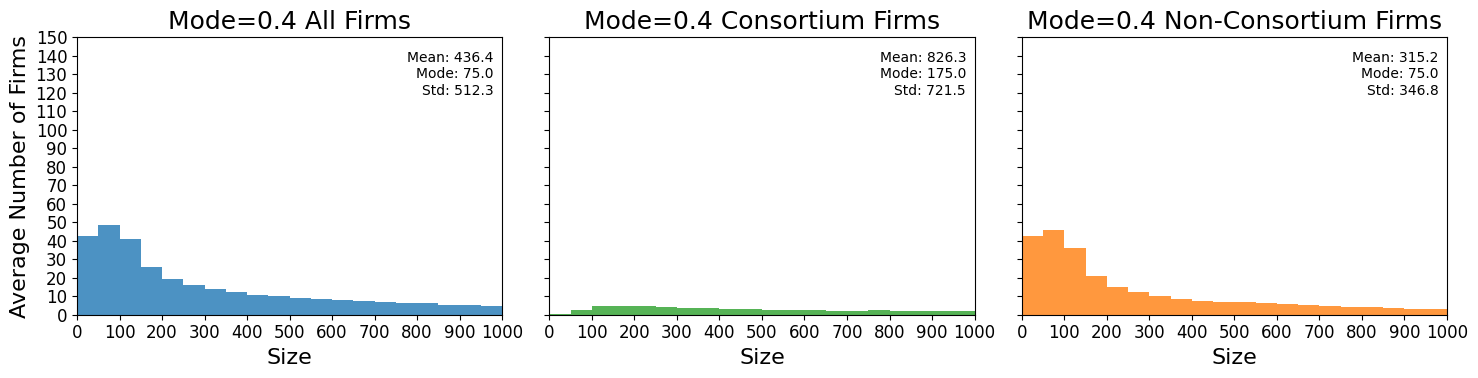

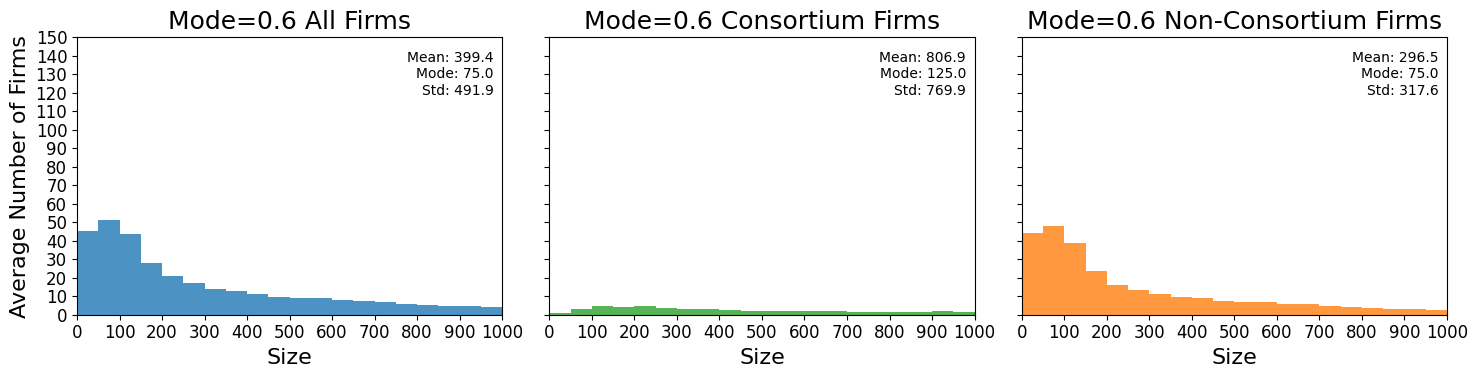

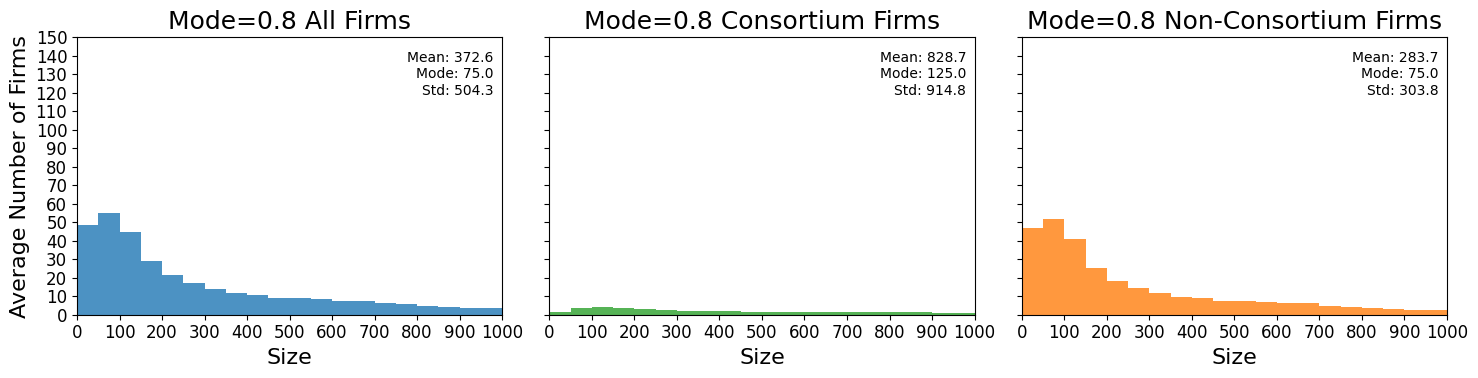

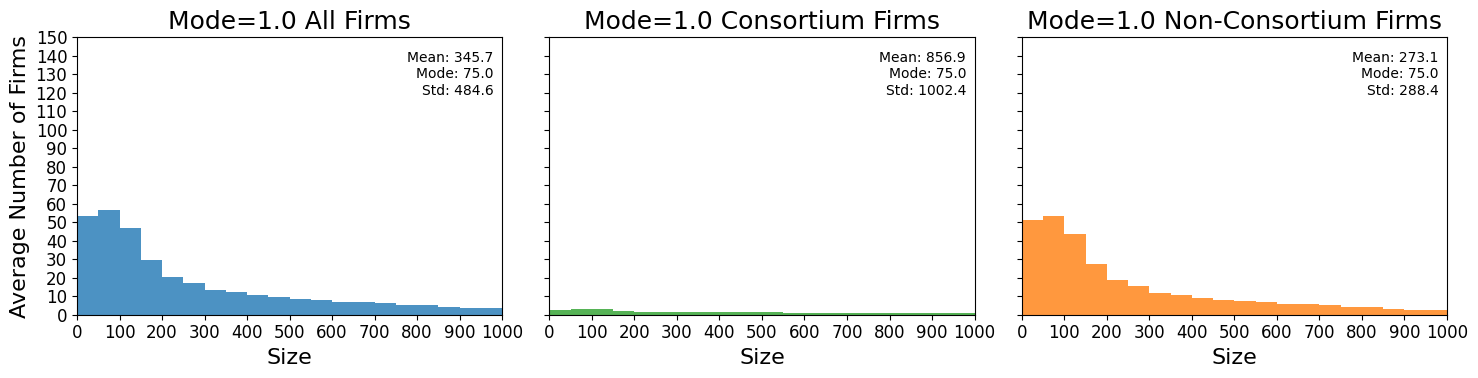

,mode,group,mean,mode(bin_center),std
0,0.0,All Firms,509.974672,75.0,510.546522
1,0.0,Consortium Firms,817.197918,225.0,579.706799
2,0.0,Non-Consortium Firms,366.985302,75.0,401.482323
3,0.2,All Firms,472.885759,75.0,512.488811
4,0.2,Consortium Firms,814.980303,175.0,642.951872
5,0.2,Non-Consortium Firms,340.975212,75.0,376.819264
6,0.4,All Firms,436.446955,75.0,512.340037
7,0.4,Consortium Firms,826.277181,175.0,721.473102
8,0.4,Non-Consortium Firms,315.184617,75.0,346.773293
9,0.6,All Firms,399.384566,75.0,491.884672


In [ ]:
import sys, os
sys.path.insert(0, os.getcwd())

for mod in ['config', 'model.helpers', 'model.simulator', 'analysis.gini', 'analysis.visualize']:
    if mod in sys.modules:
        del sys.modules[mod]

from analysis.visualize import (
    compute_time_series, plot_time_series, plot_gini_coefficients,
    plot_avg_size_histograms
)
import numpy as np
import matplotlib.pyplot as plt
from config import PARAMS, MODES

turns = np.arange(0, PARAMS['TURNS'] + 1)
modes = MODES
colors = plt.cm.viridis(np.linspace(0, 1, len(modes)))

# ① 企業数推移
mode_data_cons, mode_data_non, mode_data_total = [], [], []
for mode in modes:
    dat_cons, dat_non = compute_time_series(mode, return_size_sum=False)
    mode_data_cons.append(dat_cons)
    mode_data_non.append(dat_non)
    mode_data_total.append(dat_cons + dat_non)

plt.figure(figsize=(10,7))
for i, mode in enumerate(modes):
    plt.plot(turns, mode_data_cons[i], '-',  color=colors[i], label=f"{mode:.1f} Con")
    plt.plot(turns, mode_data_non[i],  '--', color=colors[i], label=f"{mode:.1f} Non-Con")
    plt.plot(turns, mode_data_total[i],':',  color=colors[i], label=f"{mode:.1f} Total")
plt.xlabel('Turn')
plt.ylabel('Number of Firms')
plt.title('Consortium / Non-Consortium / Total Firms Over Time')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# ② 企業サイズ合計推移
mode_data_cons_size, mode_data_non_size, mode_data_total_size = [], [], []
for mode in modes:
    dat_cons_size, dat_non_size = compute_time_series(mode, return_size_sum=True)
    mode_data_cons_size.append(dat_cons_size)
    mode_data_non_size.append(dat_non_size)
    mode_data_total_size.append(dat_cons_size + dat_non_size)

plt.figure(figsize=(10,7))
for i, mode in enumerate(modes):
    plt.plot(turns, mode_data_cons_size[i], '-',  color=colors[i], label=f"{mode:.1f} Con")
    plt.plot(turns, mode_data_non_size[i],  '--', color=colors[i], label=f"{mode:.1f} Non-Con")
    plt.plot(turns, mode_data_total_size[i],':',  color=colors[i], label=f"{mode:.1f} Total")
plt.xlabel('Turn')
plt.ylabel('Total Size of Firms')
plt.title('Consortium / Non-Consortium / Total Firm Size Over Time')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# ③ Gini係数
plot_gini_coefficients()

# ④ ヒストグラム + 要求②の統計表
hist_summary_df = plot_avg_size_histograms()


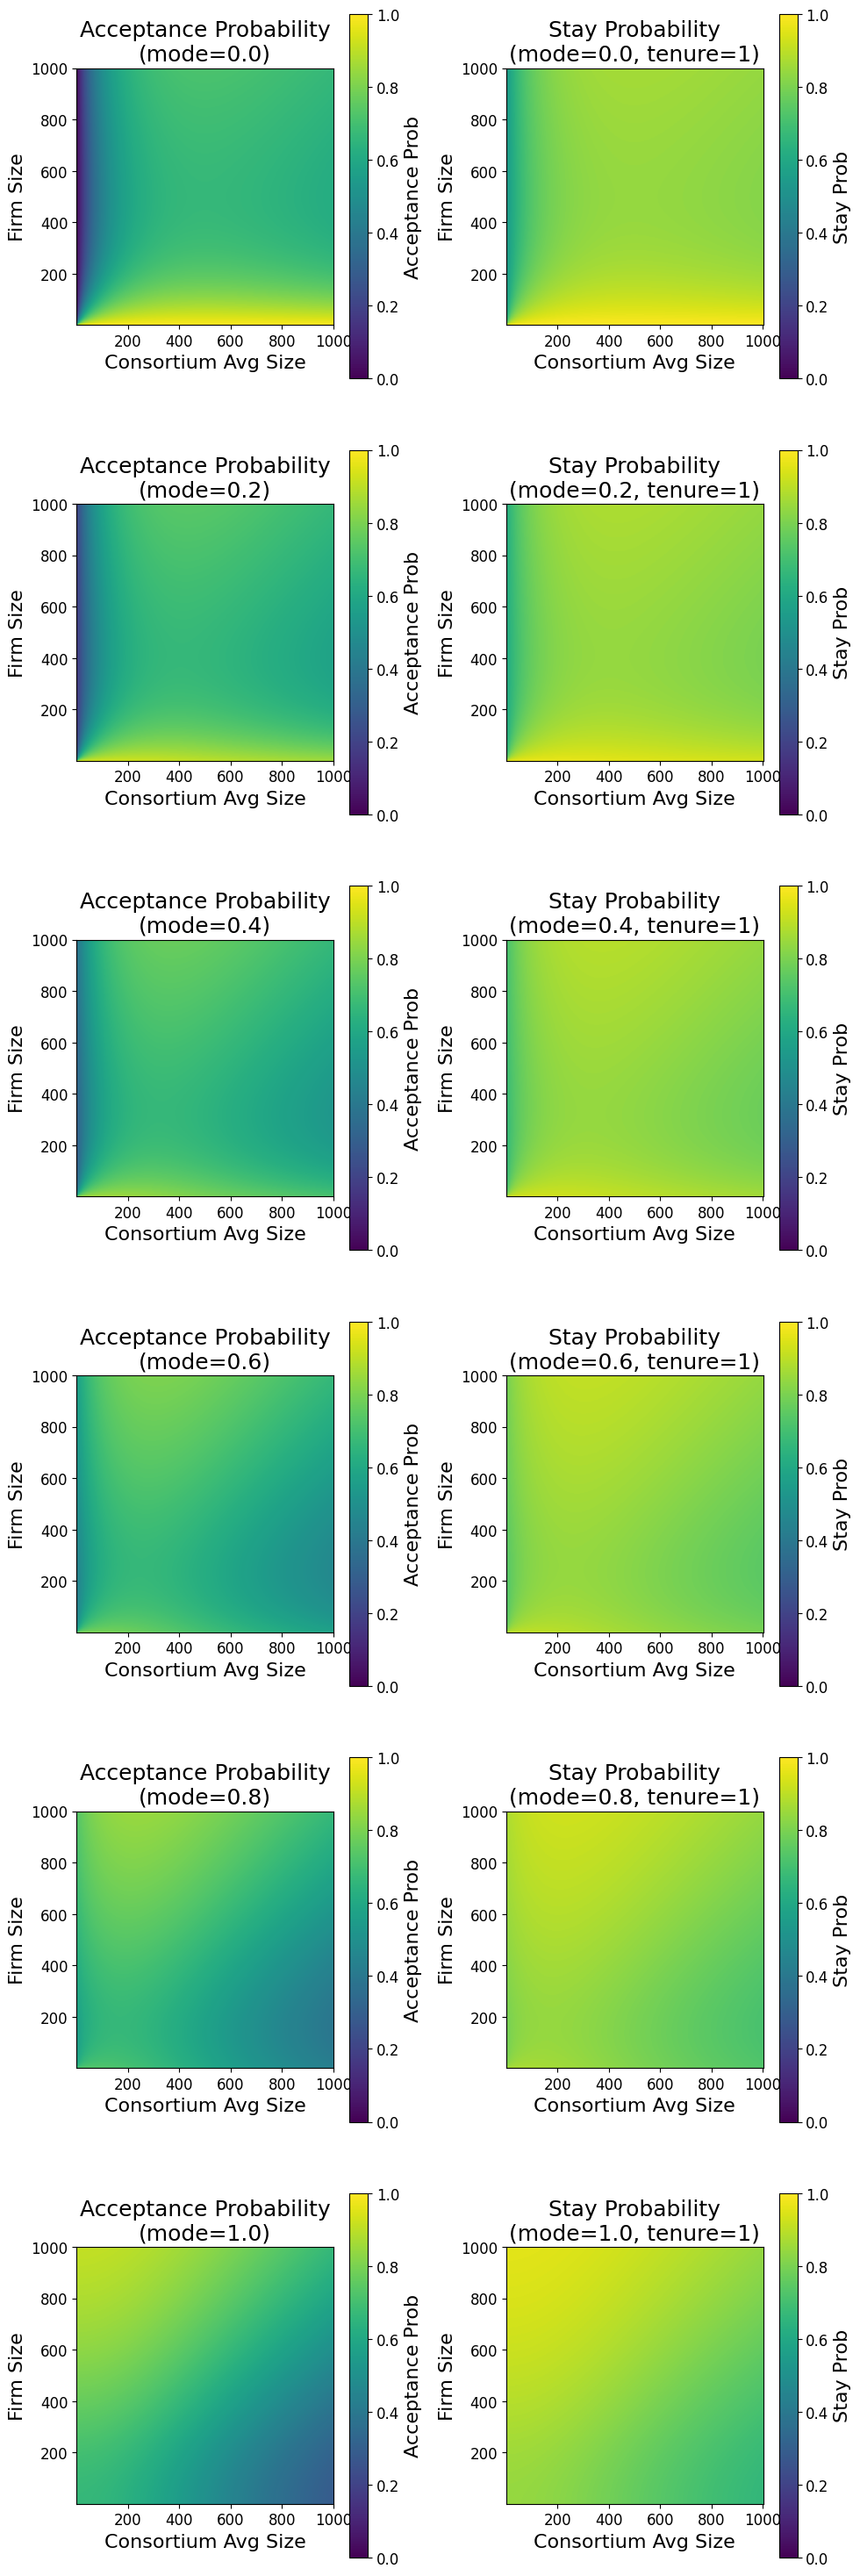

,mode,small(bottom20%)_join_mean,small(bottom20%)_stay_mean,large(top20%)_join_mean,large(top20%)_stay_mean
0,0.0,0.796285,0.902993,0.630852,0.824215
1,0.2,0.738364,0.875411,0.663209,0.839623
2,0.4,0.680442,0.847830,0.695566,0.855031
3,0.6,0.622521,0.820248,0.727923,0.870439
4,0.8,0.564600,0.792667,0.760280,0.885848
5,1.0,0.506679,0.765085,0.792637,0.901256


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from config import PARAMS, MODES, BASE_SEED
from model.helpers import p_join_equal, p_join_profit

def p_profit_based(avg, size, mode, params=PARAMS):
    p_eq = p_join_equal(np.array([avg]), size, params)
    p_pf = p_join_profit(np.array([avg]), size, params)
    return (1 - mode) * p_eq + mode * p_pf

avg_sizes  = np.linspace(1, 1000, 1000)
firm_sizes = np.linspace(1, 1000, 1000)
AVG, SIZE  = np.meshgrid(avg_sizes, firm_sizes)

modes = MODES

sigma0 = PARAMS.get('INERTIA_STATIC', 0.0)
sigma1 = PARAMS.get('INERTIA_DYNAMIC', 0.0)
tenure = 1

# 企業規模の下位20%/上位20%の閾値
q20 = np.quantile(firm_sizes, 0.2)
q80 = np.quantile(firm_sizes, 0.8)

heatmap_summary_rows = []

fig, axes = plt.subplots(nrows=len(modes), ncols=2, figsize=(10, 5 * len(modes)))

for idx, mode in enumerate(modes):
    # ベクトル化して計算（高速）
    # p_profit_basedはスカラー想定なので、ここではループで作る
    P_JOIN = np.zeros_like(AVG)
    P_STAY = np.zeros_like(AVG)

    for i in range(AVG.shape[0]):
        for j in range(AVG.shape[1]):
            avg  = AVG[i, j]
            size = SIZE[i, j]
            p = p_profit_based(avg, size, mode)
            P_JOIN[i, j] = p
            p_leave = (1 - p) / (1 + sigma0 + sigma1 * tenure)
            P_STAY[i, j] = 1 - p_leave

    # --- 要求③: 小規模/大規模の平均参加・残留確率 ---
    small_mask = SIZE <= q20
    large_mask = SIZE >= q80

    small_join_mean = P_JOIN[small_mask].mean()
    small_stay_mean = P_STAY[small_mask].mean()
    large_join_mean = P_JOIN[large_mask].mean()
    large_stay_mean = P_STAY[large_mask].mean()

    heatmap_summary_rows.append({
        "mode": mode,
        "small(bottom20%)_join_mean": small_join_mean,
        "small(bottom20%)_stay_mean": small_stay_mean,
        "large(top20%)_join_mean": large_join_mean,
        "large(top20%)_stay_mean": large_stay_mean
    })

    # --- プロット ---
    ax1 = axes[idx, 0]
    c1 = ax1.pcolormesh(AVG, SIZE, P_JOIN, shading='auto', vmin=0, vmax=1, cmap='viridis')
    ax1.set_xlabel('Consortium Avg Size')
    ax1.set_ylabel('Firm Size')
    ax1.set_title(f'Acceptance Probability\n(mode={mode:.1f})')
    fig.colorbar(c1, ax=ax1, label='Acceptance Prob')
    ax1.set_aspect('equal')

    ax2 = axes[idx, 1]
    c2 = ax2.pcolormesh(AVG, SIZE, P_STAY, shading='auto', vmin=0, vmax=1, cmap='viridis')
    ax2.set_xlabel('Consortium Avg Size')
    ax2.set_ylabel('Firm Size')
    ax2.set_title(f'Stay Probability\n(mode={mode:.1f}, tenure={tenure})')
    fig.colorbar(c2, ax=ax2, label='Stay Prob')
    ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

# === 要求③の統計表 ===
heatmap_summary_df = pd.DataFrame(heatmap_summary_rows)
display(heatmap_summary_df)


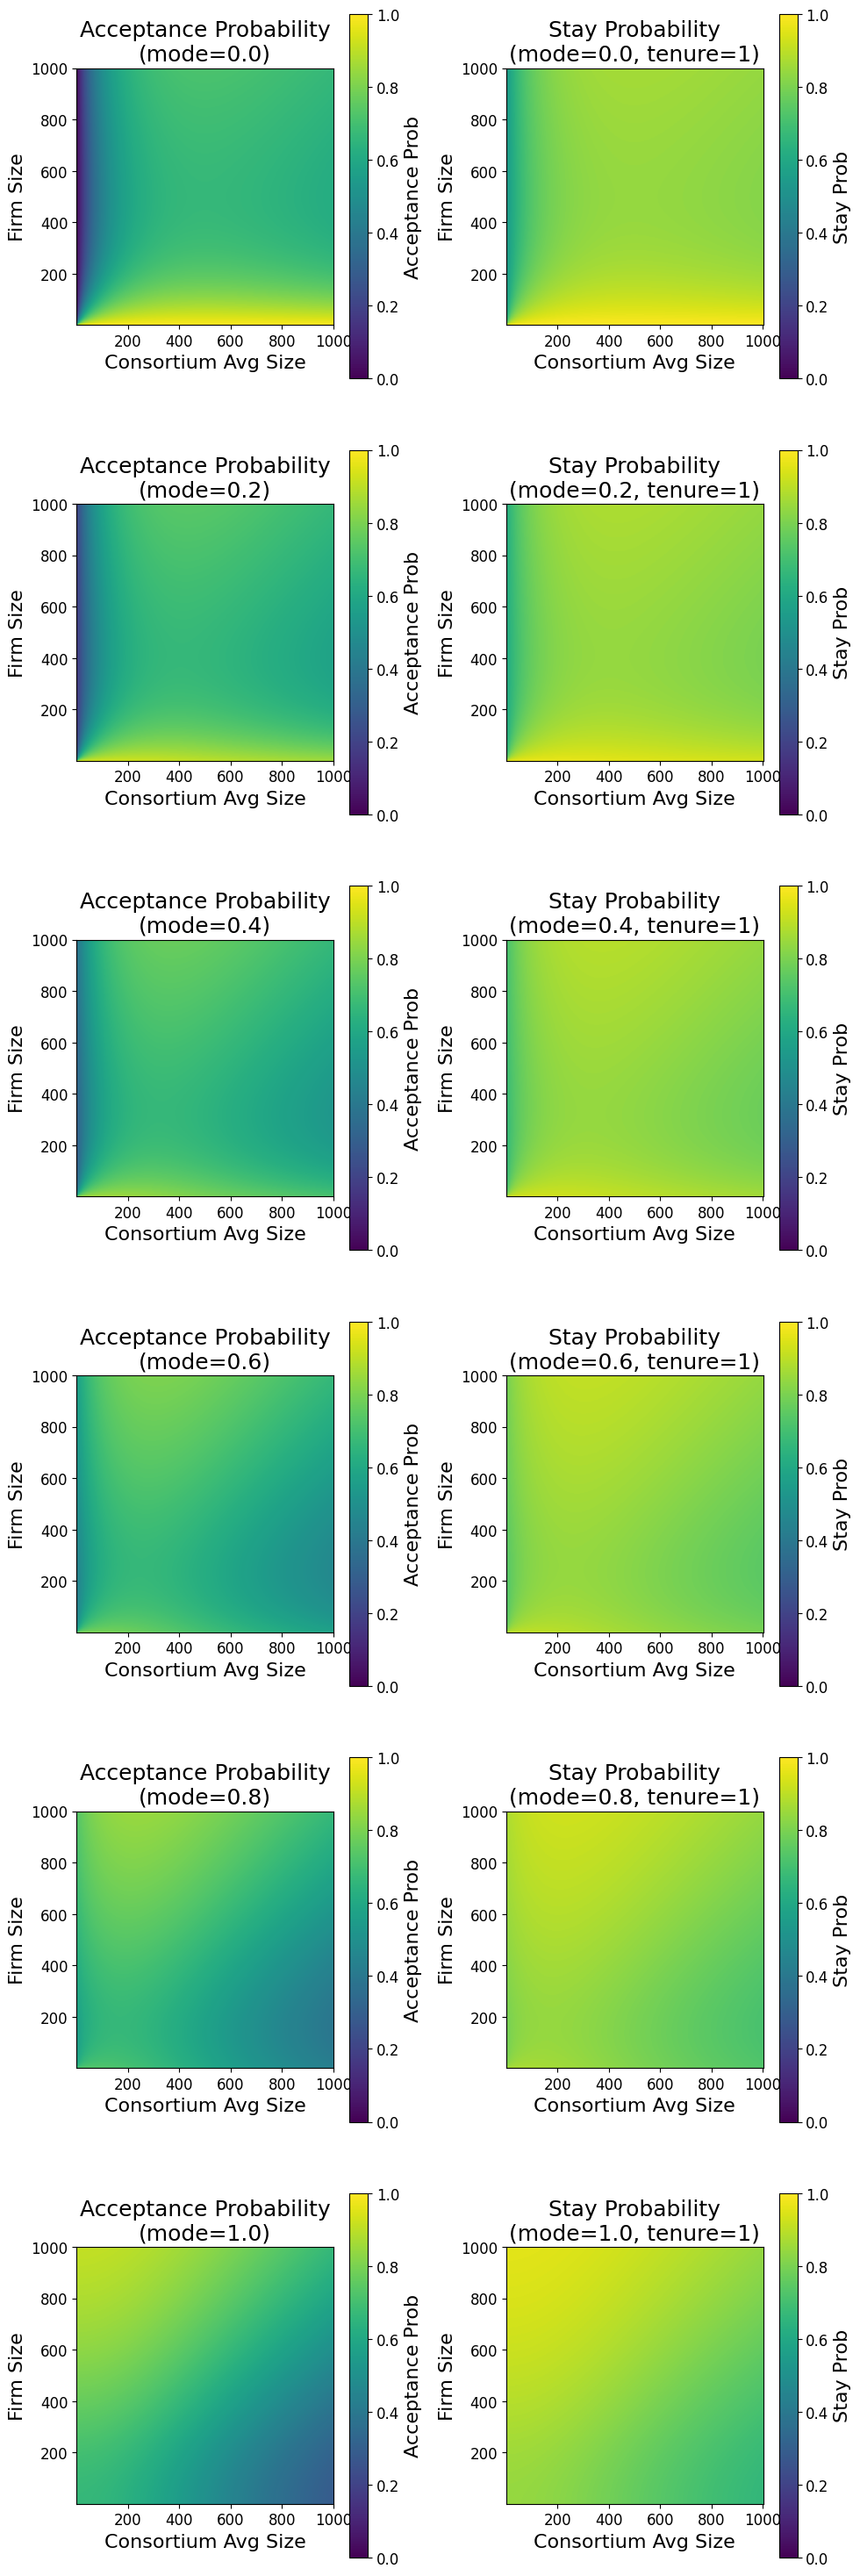

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from config import PARAMS
from model.helpers import p_join_equal, p_join_profit

def p_profit_based(avg, size, mode, params=PARAMS):
    p_eq = p_join_equal(np.array([avg]), size, params)
    p_pf = p_join_profit(np.array([avg]), size, params)
    return (1 - mode) * p_eq + mode * p_pf

avg_sizes = np.linspace(1, 1000, 1000)
firm_sizes = np.linspace(1, 1000, 1000)
AVG, SIZE = np.meshgrid(avg_sizes, firm_sizes)

modes = np.arange(0, 1.01, 0.2)

sigma0 = PARAMS.get('INERTIA_STATIC', 0.0)
sigma1 = PARAMS.get('INERTIA_DYNAMIC', 0.0)
tenure = 1

# 各プロットを正方形にしたいので、figsizeを十分大きく正方形に
fig, axes = plt.subplots(nrows=len(modes), ncols=2, figsize=(10, 5 * len(modes)))

for idx, mode in enumerate(modes):
    P_JOIN = np.zeros_like(AVG)
    P_STAY = np.zeros_like(AVG)
    for i in range(AVG.shape[0]):
        for j in range(AVG.shape[1]):
            avg = AVG[i, j]
            size = SIZE[i, j]
            p = p_profit_based(avg, size, mode)
            P_JOIN[i, j] = p
            p_leave = (1 - p) / (1 + sigma0 + sigma1 * tenure)
            P_STAY[i, j] = 1 - p_leave

    ax1 = axes[idx, 0]
    c1 = ax1.pcolormesh(AVG, SIZE, P_JOIN, shading='auto', vmin=0, vmax=1, cmap='viridis')
    ax1.set_xlabel('Consortium Avg Size')
    ax1.set_ylabel('Firm Size')
    ax1.set_title(f'Acceptance Probability\n(mode={mode:.1f})')
    fig.colorbar(c1, ax=ax1, label='Acceptance Prob')
    ax1.set_aspect('equal')  # ここが重要

    ax2 = axes[idx, 1]
    c2 = ax2.pcolormesh(AVG, SIZE, P_STAY, shading='auto', vmin=0, vmax=1, cmap='viridis')
    ax2.set_xlabel('Consortium Avg Size')
    ax2.set_ylabel('Firm Size')
    ax2.set_title(f'Stay Probability\n(mode={mode:.1f}, tenure={tenure})')
    fig.colorbar(c2, ax=ax2, label='Stay Prob')
    ax2.set_aspect('equal')  # ここが重要

plt.tight_layout()
plt.show()
